# Converts raw files to tiff/npy

In [49]:
#the below functions identifies the files with the term 'roi' for conversion
phrase_list1 = ['283935Right','290336Left','290336Right','295106Left','295106Right']
phrase_list2 = ['380166Right','383193Left','383193Right','385151Left','385151Right']
phrase_list3 = ['457036Left','457036Right']
phrase_list4 = ['113994Left','139486Right','157925Right','183417Right','186714Left','186714Right','187456Left']
ROI_KU = []
ROI_EM = []
ROI_MA = []
ROI_UB = []
def get_files(path):
    raw_path = path
    pt_fnames = []

    for root, dirs, files in os.walk(raw_path):
        for name in files:
            pt_fnames.append(name)
    #print(pt_fnames)

    print('The directory is correct!')
    for filename in pt_fnames:
        for phrase in phrase_list3:
            phrase1 =phrase[0:6]
            #print(phrase1)
            phrase2 = phrase[6:]
            #print(phrase2)
            if 'Image' in filename:
                continue
            if 'ROI' in os.path.basename(filename):
                if phrase1 in filename:
                    if phrase2 in filename:
                        ROI_UB.append(filename)

    print('\nFiles have been identified.\n')
    print(str(len(ROI_UB)) + ' files have been copied and moved.')

    print(ROI_UB)

get_files(r"C:\Users\UAB\data\UAB\Original")

The directory is correct!

Files have been identified.

16 files have been copied and moved.
['457036 y0 Cyst ROI Left 8bit 110 169 105', '457036 y0 Cyst ROI Right 8bit 102 142 105', '457036 y0 Kidney ROI Left 8bit 110 169 105', '457036 y0 Kidney ROI Right 8bit 102 142 105', '457036 y1 Cyst ROI Left 8bit 112 163 105', '457036 y1 Cyst ROI Right 8bit 101 146 105', '457036 y1 Kidney ROI Left 8bit 112 163 105', '457036 y1 Kidney ROI Right 8bit 101 146 105', '457036 y2 Cyst ROI Left 8bit 118 158 105', '457036 y2 Cyst ROI Right 8bit 101 141 105', '457036 y2 Kidney ROI Left 8bit 118 158 105', '457036 y2 Kidney ROI Right 8bit 101 141 105', '457036 y3 Cyst ROI Left 8bit 118 161 111', '457036 y3 Cyst ROI Right 8bit 106 138 111', '457036 y3 Kidney ROI Left 8bit 118 161 111', '457036 y3 Kidney ROI Right 8bit 106 138 111']


In [50]:
import re

# Example filename
filenames = ROI_UB

results = []
# Iterate over each filename
for filename in filenames:
    if 'Cyst' in filename:
        results.append(filename)

# Print the results
print(results)


['457036 y0 Cyst ROI Left 8bit 110 169 105', '457036 y0 Cyst ROI Right 8bit 102 142 105', '457036 y1 Cyst ROI Left 8bit 112 163 105', '457036 y1 Cyst ROI Right 8bit 101 146 105', '457036 y2 Cyst ROI Left 8bit 118 158 105', '457036 y2 Cyst ROI Right 8bit 101 141 105', '457036 y3 Cyst ROI Left 8bit 118 161 111', '457036 y3 Cyst ROI Right 8bit 106 138 111']


In [4]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Interpolating nii files

In [8]:
import os
import nibabel as nib
import numpy as np

input_folder = r'D:\Data_96\uab\nii'
output_folder = r'D:\Data_96\128_Slices\NII'
target_num_slices = 128  # define the desired number of slices for interpolation

# Loop over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename) #define input and output paths
        output_path = os.path.join(output_folder, filename) 
        img = nib.load(input_path) # load data
        data = img.get_fdata()  #get the array objects
        old_shape = data.shape   #get shape and slice number
        old_num_slices = old_shape[-1]
        new_num_slices = target_num_slices 
        new_shape = list(old_shape) #defining new shape
        new_shape[-1] = new_num_slices
        new_data = np.zeros(new_shape, dtype=data.dtype) #creating tensor to hold the resized image
        # Resample the data using linear interpolation
        zoom_factor = (old_num_slices - 1) / (new_num_slices - 1) #interpolation factor
        for i in range(new_num_slices): #looping through imaged wrt slice number and interpolating
            z = i * zoom_factor
            z0 = int(np.floor(z))
            z1 = int(np.ceil(z))
            if z0 == z1:
                new_data[..., i] = data[..., z0]
            else:
                new_data[..., i] = ((z1 - z) * data[..., z0] +
                                    (z - z0) * data[..., z1])
        # Create a new NIfTI image and save it to disk
        new_img = nib.Nifti1Image(new_data, img.affine, img.header) #getting reconstructed image from array
        nib.save(new_img, output_path) #save image



# Resize Images. Use below code if aspect ratio has to be maintained

In [4]:
#define the old, target size, new width, height and overwrite the new image on old image for resizing.
#the padding function only defines the padded height, width and length
def padding(img, expected_size):
    desired_size = expected_size
    width, height = img.size
    delta_width = desired_size - width  #diff between original and padded width is found to ensure proper resizing
    delta_height = desired_size - height
    pad_width = delta_width // 2  #padded dimensions are the half the original dimensions
    pad_height = delta_height // 2
    padded_img = Image.new(img.mode, (desired_size, desired_size)) #image mode can be changed based on the data
    padded_img.paste(img, (pad_width, pad_height)) #overwriting
    return padded_img

#the resize with padding function defines the padded height, width and length to be overlayed on the image
def resize_with_padding(img, expected_size):
    width, height = img.size
    aspect_ratio = width / height
    target_aspect_ratio = expected_size[0] / expected_size[1] #aspect ratio is determined

#based on the aspect ratio, the conditional loop is initialized for resizing
    if aspect_ratio > target_aspect_ratio:
        new_width = expected_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = expected_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

    delta_width = expected_size[0] - new_width
    delta_height = expected_size[1] - new_height
    pad_width = delta_width // 2
    pad_height = delta_height // 2

    padded_img = Image.new(img.mode, (expected_size[0], expected_size[1]))
    padded_img.paste(resized_img, (pad_width, pad_height))
    return padded_img

# Resize Images. Use below code if aspect ratio can be ignored

In [ ]:
#same function as above except the aspect ratio is not defined
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


In [6]:
#the below functions identifies the files with the term 'roi' for conversion
def get_files(path):
    raw_path = path
    pt_fnames = []

    for root, dirs, files in os.walk(raw_path):
        for name in files:
            pt_fnames.append(os.path.join(root, name))

    print('The directory is correct!')
    
    ROI_list = []
    for filename in pt_fnames:
        if 'ROI' in os.path.basename(filename):
            ROI_list.append(filename)

    print('\nFiles have been identified.\n')
    print(str(len(ROI_list)) + ' files have been copied and moved.')

    return ROI_list

# Use the below code to convert binary to npy and nii

In [7]:
#the below function convert the identified roi files to npy for further processing
import os
import numpy as np
import nibabel as nib
from PIL import Image

def convert_files(roi_list):
    print(f'Converting {len(roi_list)} files')
    new_size = 256
#loop over the files names in the roi list and gather file names based on string slicing method
    for roi_file in roi_list:
        orig_filename = os.path.basename(roi_file)
        print(orig_filename)
#loop over the files names in the roi list and gather file dimensions
        num_slices = int(orig_filename[-3:])
        num_width = int(orig_filename[-8:-4])
        num_height = int(orig_filename[-12:-8])
#the below conditional loop determines the file name wrt the num_Slices present in the data. This is a primitive method. Improvements can be done if mult-type data is used. Other conditions can be removed if the data has uniform slices or name length
        if num_slices < 15:
            num_slices, num_width, num_height = int(orig_filename[-3:]), int(orig_filename[-7:-4]), int(orig_filename[-11:-8])
        elif num_slices < 50:
            num_slices, num_width, num_height = int(orig_filename[-3:]), int(orig_filename[-8:-4]), int(orig_filename[-12:-8])
        else:
            num_width, num_height = int(orig_filename[-7:-3]), int(orig_filename[-11:-7])

        patient_number = orig_filename[:6]
        year_number = orig_filename[8] if orig_filename[8].isdigit() else orig_filename[7]
#based on the type of data, C or K or M is assigned in the name
        if 'Cyst' in orig_filename:
            image_type = 'C'
        elif 'Kidney' in orig_filename:
            image_type = 'K'
        elif 'Image' in orig_filename:
            image_type = 'M'

        side = 'R' if 'Right' in orig_filename else 'L'
#conveting the files to 8 bit and resizing
        call_file = str(roi_file)
        resized = np.zeros((num_slices, new_size, new_size), dtype='uint8')
        transposed = np.zeros((new_size, new_size, num_slices), dtype='uint8')

        with open(call_file, 'rb') as file:
            data = np.fromfile(file, dtype='uint8').reshape(num_slices, num_width, num_height)

            for j, orig_slice in enumerate(data):
                re_slice = Image.fromarray(orig_slice)
                resized[j] = resize_with_padding(re_slice, (new_size, new_size))

            for i, old_slice in enumerate(resized):
                transposed[:, :, i] = old_slice
#conveting the files to npy and nii
        new_filename = f"{patient_number}_{year_number}_{num_slices}_{side}_{image_type}"
        file_path = os.path.join(final_path, new_filename)

        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, file_path)

    print("Conversion Successful!")



# Use the below code to convert binary to tiff

In [ ]:
import os
import numpy as np
import nibabel as nib
import tifffile

def convert_files_tiff(roi_list):
    print(f'Converting {len(roi_list)} files')

    for roi_file in roi_list:
        orig_filename = os.path.basename(roi_file)
        print(orig_filename)

        num_slices = int(orig_filename[-3:])
        num_width = int(orig_filename[-8:-4])
        num_height = int(orig_filename[-12:-8])

        if num_slices < 15:
            num_slices, num_width, num_height = int(orig_filename[-3:]), int(orig_filename[-7:-4]), int(orig_filename[-11:-8])
        elif num_slices < 50:
            num_slices, num_width, num_height = int(orig_filename[-3:]), int(orig_filename[-8:-4]), int(orig_filename[-12:-8])
        else:
            num_width, num_height = int(orig_filename[-7:-3]), int(orig_filename[-11:-7])

        patient_number = orig_filename[:6]
        year_number = orig_filename[8] if orig_filename[8].isdigit() else orig_filename[7]

        if 'Cyst' in orig_filename:
            image_type = 'C'
        elif 'Kidney' in orig_filename:
            image_type = 'K'
        elif 'Image' in orig_filename:
            image_type = 'M'

        side = 'R' if 'Right' in orig_filename else 'L'

        call_file = str(roi_file)
        data = np.fromfile(call_file, dtype='uint8').reshape(num_slices, num_width, num_height)

        new_filename = f"{patient_number}_{year_number}_{num_slices}_{side}_{image_type}.tiff"
        file_path = os.path.join(final_path, new_filename)

        with open(file_path, 'wb') as file:
            nifti_image = nib.Nifti1Image(data, np.eye(4))
            nifti_image.to_filename(file)

    print("Conversion Successful!")


# Path Information
Make sure you have 4 folders in your working directory as seen below to avoid folder not found error

In [7]:
raw_path = r'C:\Users\UAB\data\UAB\Original'
new_path = r'D:\NPY'
final_path = r'D:\Data_3D\UAB\NII'
cyst_path = r'D:\Cyst'
new_size = 128

In [9]:
lists = get_files(raw_path)


Patient Folders have been identified


Filenames have been found and added

copied and moved 204 files


In [10]:
orig_fname = lists[2]
num_slice = int(orig_fname[-3:])
num_width = int((orig_fname[-7:-4]))
            #print(num_width)
num_height = int((orig_fname[-11:-8]))

print(num_slice, num_width, num_height)

95 26 21


In [33]:
convert(lists) 

Converting 204 files
407132 y0 Cyst ROI Left 8bit 212 260 95
407132 y0 Cyst ROI Right 8bit 230 263 95
407132 y0 Image ROI Left 8bit 212 260 95
407132 y0 Image ROI Right 8bit 230 263 95
407132 y0 Kidney ROI Left 8bit 212 260 95
407132 y0 Kidney ROI Right 8bit 230 263 95
407132 y1 Cyst ROI Left 8bit 229 269 69
407132 y1 Cyst ROI Right 8bit 231 318 69
407132 y1 Image ROI Left 8bit 229 269 69
407132 y1 Image ROI Right 8bit 231 318 69
407132 y1 Kidney ROI Left 8bit 229 269 69
407132 y1 Kidney ROI Right 8bit 231 318 69
407132 y2 Cyst ROI Left 8bit 200 280 95
407132 y2 Cyst ROI Right 8bit 221 271 95
407132 y2 Image ROI Left 8bit 200 280 95
407132 y2 Image ROI Right 8bit 221 271 95
407132 y2 Kidney ROI Left 8bit 200 280 95
407132 y2 Kidney ROI Right 8bit 221 271 95
407132 y3 Cyst ROI Left 8bit 222 312 75
407132 y3 Cyst ROI Right 8bit 226 322 75
407132 y3 Image ROI Left 8bit 222 312 75
407132 y3 Image ROI Right 8bit 226 322 75
407132 y3 Kidney ROI Left 8bit 222 312 75
407132 y3 Kidney ROI Right

492327 y2 Image ROI Right 8bit 129 200 140
492327 y2 Kidney ROI Left 8bit 123 172 140
492327 y2 Kidney ROI Right 8bit 129 200 140
492327 y3 Cyst ROI Left 8bit 128 180 140
492327 y3 Cyst ROI Right 8bit 128 211 140
492327 y3 Image ROI Left 8bit 128 180 140
492327 y3 Image ROI Right 8bit 128 211 140
492327 y3 Kidney ROI Left 8bit 128 180 140
492327 y3 Kidney ROI Right 8bit 128 211 140
complete --- nice job


# Relocate masks for convenience

In [6]:
#the below code helps in copy/moving specific files based on specific requirements like phrase or a term
import os
import shutil
path = r'D:\Lung\Keras\npy1\\'
cyst_path = r"D:\Lung\Pytorch\labels1\\"
cyst_names=[]
for root, dirs, files in os.walk(os.path.normpath(path), topdown=True):
    for name in files:
        #print(os.path.join(root, name))
        cyst_names.append(os.path.join(root, name))

C_list = []
for j in range(len(cyst_names)):
    C_name = 'K.npy'  
    #R_name = '113994_1_99_'
    filename = os.path.basename(cyst_names[j])
    if C_name in filename:
    #if C_name in filename:
     #   if R_name in filename:
        C_list.append(cyst_names[j])
for i in range(len(C_list)):
    shutil.copy(C_list[i],cyst_path ) #copy eill retain source file in the original place
    #shutil.move(C_list[i],cyst_path ) # moving will delete the file from the original place

# Use the below codes for 3D Training

# Resize 3D NII image along z axis with interpolation


In [ ]:
import numpy as np
import nibabel as nib
from nilearn.image import resample_img
data_path = r'D:\Data_3D\Emory\NII'
new_path = r'D:\Data_3D\Emory\NII_Reshaped'
new_path1 = r'D:\Data_3D\Emory\NPY_Reshaped'
images = gather_set(data_path, '_C.')
print(len(images))
for i in range(len(images)):
    working_img = nib.load(data_path + '\\' + images[i]) #load image
    print(working_img.shape)
    target_shape = np.array((256,256,128)) #create tensor with new size
    new_resolution = [1,]*3 #set resolution 
    new_affine = np.zeros((4,4)) #set new affine for image information
    new_affine[:3,:3] = np.diag(new_resolution) #Sets the diagonal elements of the first three rows of the affine matrix as the new resolution.
    # putting point 0,0,0 in the middle of the new volume - this could be refined in the future
    new_affine[:3,3] = target_shape*new_resolution/2.*0
    new_affine[3,3] = 1
    nii_image = resample_img(working_img, target_affine=new_affine, target_shape=target_shape, interpolation='nearest') #resize with interpolation
    file_name = images[i][:-6]
    new_fname = str(file_name + '_C')
    
    print(nii_image.shape)
    npy_image = nii_image.get_fdata()
    np.save(os.path.join(new_path1, new_fname), npy_image) #save the image
    print(npy_image.shape)

# Resize 3D NII image along z axis without interpolation

In [ ]:
#same as above except affine and interpolation are ignored

import numpy as np
import nibabel as nib
from nilearn.image import resample_img
data_path = r'D:\Data\KU\nii1'
#data_path= r'C:\Users\UAB\data\UAB\AllNIIImages'
new_path = r'D:\Data\KU\nii2'
new_path1 = r'D:\Data\KU\npy2'
images = gather_set(data_path, '_K.')
print(len(images))
for i in range(len(images)):
    
    working_img = nib.load(data_path + '\\' + images[i])
    affine = working_img.affine

    nii_image = resample_img(working_img, affine, (128,128,32))
    file_name = images[i][:-5]
    new_fname = str(file_name + 'K')
    nib.save(nii_image, os.path.join(new_path, new_fname))
    print(nii_image.shape)
    npy_image = nii_image.get_fdata()
    np.save(os.path.join(new_path1, new_fname), npy_image)
    print(npy_image.shape)

# Stack npy images into 3D

In [2]:
#below defines a function to get the images (M) and masks (K or C)
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of
data_path = r'D:\Data\Mayo\NPY_Sliced'
#data_path= r'C:\Users\UAB\data\UAB\AllNIIImages'
new_path = r'D:\Data\Mayo\data'
new_path1 = r'D:\Data\Mayo\nii1'
labels = gather_set(data_path, '_M.')
print(len(labels))
for i in range(len(labels)):
    a = np.load(data_path + '\\' + labels[i]) #load npy file
    b=np.dstack([a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a]) #here the same is stacked with itself to create artificial data to increase training sample. This can be modified. 
    file_name = labels[i][:-5]
    name = str(file_name +'M')
    name2 = str(file_name +'M')    
    np.save(os.path.join(new_path, name), b)
    affine = np.eye(4) #create affine to convert npy to nii
    nifti_file = nib.Nifti1Image(b, affine) #convert npy to nii
    nib.save(nifti_file, os.path.join(new_path1, "%s" %name2)) #save nii file

# Use below codes for 2D Training

# Save as single slices


In [14]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of



In [114]:
#if the data is npy, use object slicing method as below
data_path = r"D:\Data\UAB\NPY"
new_path = r"D:\Data\UAB\data"


labels = gather_set(data_path, '_L_M')


for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-7]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j] #object slicing
        new_fname = str(file_name + str(j) +'_L_M')
        np.save(os.path.join(new_path, new_fname), save_slice)


KeyboardInterrupt: 

In [42]:
#if the data is npy, use affine slicing method as below
for i in range(len(images)):
    working_img = nib.load(data_path + '\\' + images[i])
    working_img = working_img.get_fdata()
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j] #affine slicing 
        new_fname = str(file_name + str(j) +'_M')
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(save_slice, affine)
        nib.save(nifti_file, os.path.join(new_path, "%s" %new_fname))

# Binarize the masks (background = 0 and Kid/cys = 1)

In [31]:
for i in range(len(seg_list)):
    segment = nib.load(data_path+"\\"+seg_list[i])
    seg_data = segment.get_fdata()
    binarized = np.where(seg_data>1,1,seg_data) #consdering only the regions where mask is present and is set to 1 and rest is set to 0
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(binarized, affine)
    nib.save(nifti_file, os.path.join(bin_path, "%s" %seg_list[i]))

# The below code takes in exceptional raw file cases which weren't converted using the above convert fucntion due to size mismatch or naming convention mismatch. These problems are addressed below. 

In [8]:
def convert(ROI_list):
    #new_size= new_size
    print('Converting', str(len(ROI_list)), 'files')
    for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
        orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
        print(orig_fname)
        #extract information from the filename
        if orig_fname[0].isdigit(): 
            orig_fname = orig_fname
        else:
            orig_fname = orig_fname[3:]
        num_slice = int(orig_fname[-3:])
        #print(num_slice)
        if num_slice < 15:
            orig_fname = this_list[2]
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-7:-4]))
            #print(num_width)
            num_height = int((orig_fname[-11:-8]))
        elif num_slice < 50:
            #print('over 99')
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-8:-4]))
            #print(num_width)
            num_height = int((orig_fname[-12:-8]))
            #print(num_height)
        else:
            #print('less than 99')
            num_width = int((orig_fname[-7:-3]))
            #print(num_width)
            num_height = int((orig_fname[-10:-7]))
            #print(num_height)
        pt_numb =(orig_fname[0:6])
        yr_numb = (orig_fname[8])
        if 'Cyst' in orig_fname:
            img_type = 'C'
        elif 'Kidney' in orig_fname:
            img_type = 'M_K'
        elif 'Image' in orig_fname:
            img_type = 'M'
        if 'Right' in orig_fname:
            side = 'R'
        elif 'Left' in orig_fname:
            side = 'L'
        call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
        resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
        transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
        with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
             data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
             for j in range(num_slice):
                 orig_slice = data[j]
                 re_slice = Image.fromarray(orig_slice)
                 resized[j] = resize_with_padding(re_slice, (new_size, new_size))
             for i in range(resized.shape[0]):
                 old_slice = resized[i,:,:]
                 transposed[:,:,i] = old_slice

                 # now we need to rename this resized array and save it as a .npy
        #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
        new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
        file_name = "%s" %new_fname # add our extension
        np.save(os.path.join(new_path, file_name), transposed) # save in the new file folder
        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))


    print("complete --- nice job")

In [10]:
import os
raw_path = r'C:\Users\UAB\data\Emory\issues'
new_path = r'D:\Data_96\Emory\npy'
final_path = r'D:\Data_96\Emory\nii'
#final_path = r'D:\Data\Mayo\NII'
#cyst_path = r'C:\Users\UAB\data\Emory\c'
new_size = 128

this_list = get_files(raw_path)


convert(lists) 



Patient Folders have been identified


Filenames have been found and added

copied and moved 18 files
Converting 18 files
246620 y0 Cyst ROI Left 8bit 98 131 90
246620 y0 Image ROI Left 8bit 98 131 90
246620 y0 Kidney ROI Left 8bit 98 131 90
246620 y1 Cyst ROI Left 8bit 99 130 90
246620 y1 Image ROI Left 8bit 99 130 90
246620 y1 Kidney ROI Left 8bit 99 130 90
246620 y3 Cyst ROI Left 8bit 94 131 90
246620 y3 Image ROI Left 8bit 94 131 90
246620 y3 Kidney ROI Left 8bit 94 131 90
265171 y2 Cyst ROI Left 8bit 98 142 90
265171 y2 Cyst ROI Right 8bit 99 146 90
265171 y2 Image ROI Left 8bit 98 142 90
265171 y2 Image ROI Right 8bit 99 146 90
265171 y2 Kidney ROI Left 8bit 98 142 90
265171 y2 Kidney ROI Right 8bit 99 146 90
265171 y3 Cyst ROI Left 8bit 95 141 96
265171 y3 Image ROI Left 8bit 95 141 96
265171 y3 Kidney ROI Left 8bit 95 141 96
complete --- nice job


In [121]:

    
data_path = r"C:\Users\UAB\data\Emory\npy"
new_path = r"C:\Users\UAB\data\Emory\new"


labels = gather_set(data_path, '_K')


for i in range(len(labels)):
    working_img = np.load(data_path + '\\' + labels[i])
    file_name = labels[i][:-7]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_K')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [122]:
images = gather_set(data_path, '_M.')
for i in range(len(images)):
    working_img = np.load(data_path + '\\' + images[i])
    file_name = images[i][:-5]
    for j in range(working_img.shape[-1]):
        save_slice = working_img[:,:,j]
        new_fname = str(file_name + str(j) +'_M')
        np.save(os.path.join(new_path, new_fname), save_slice)

In [ ]:
final_path = r"C:\Users\UAB\data\Emory\new"
seg_list = gather_set(final_path, '_K')


for i in range(len(seg_list)):
    seg_data = np.load(final_path+"\\"+seg_list[i])
    file_name = seg_list[i][:-4]
    binarized = np.where(seg_data>1,1,seg_data)
    np.save(os.path.join(final_path, file_name), binarized)

In [80]:
image_test = np.load(r"C:\Users\UAB\data\Mayo\Original\Pt 303868\new\303868_0_87_L_30_M.npy")
print(image_test.max(), image_test.shape)
label_test = np.load(r"C:\Users\UAB\data\Mayo\Original\Pt 303868\new\303868_0_87_L_30_K.npy")
print(label_test.max(), label_test.shape)

249 (512, 512)
1 (512, 512)


# Plot and check if the exception cases are converted correctly

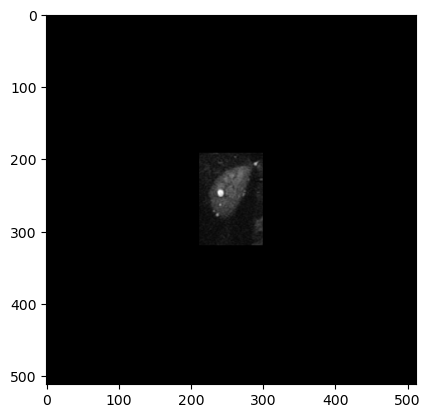

In [84]:
plt.imshow(image_test, cmap='gray')


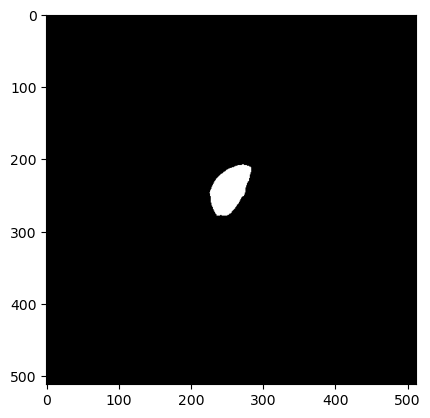

In [83]:
plt.imshow(label_test, cmap='gray')

In [13]:
#save npy files
import os

path1 = r'D:\Data_96\128_Slices\NII'
path2 = r'D:\Data_96\128_Slices\NPY'
for filename in os.listdir(path1):
    input_path = os.path.join(path1, filename)
    name = filename[:-4]
    output_path = os.path.join(path2, name)
    im = nib.load(input_path)
    im = im.get_fdata()
    np.save(output_path, im)

# Preprocessing pipeline for nifti images

In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage import exposure, filters
from skimage.transform import resize
from skimage.util import pad

def normalize_intensity(image):
    # Normalize intensity to [0, 1] range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def histogram_equalization(image):
    # Apply histogram equalization to enhance contrast
    equalized_image = exposure.equalize_hist(image)
    return equalized_image

def apply_clahe(image, clip_limit=0.01, tile_grid_size=(8, 8)):
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = exposure.equalize_adapthist(image, clip_limit=clip_limit, kernel_size=tile_grid_size)
    return clahe

def denoise_image(image, sigma):
    # Apply Gaussian smoothing for denoising
    denoised_image = filters.gaussian(image, sigma=sigma)
    return denoised_image

def resize_image(image, target_shape):
    # Resize image to target shape
    resized_image = resize(image, target_shape, order=1, mode='constant', anti_aliasing=True)
    return resized_image

def pad_image(image, target_shape):
    # Pad image to target shape
    padded_image = pad(image, [(0, target_shape[i] - image.shape[i]) for i in range(image.ndim)], mode='constant')
    return padded_image

def preprocess_nifti(nifti_path, output_dir, target_shape=(128, 128, 128), sigma=1.0, apply_clahe=False):
    img = nib.load(nifti_path)
    data = img.get_fdata()

    # Preprocessing steps
    normalized_data = normalize_intensity(data)
    equalized_data = histogram_equalization(normalized_data)

    if apply_clahe:
        clahe_data = apply_clahe(equalized_data)
        preprocessed_data = denoise_image(clahe_data, sigma)
    else:
        preprocessed_data = denoise_image(equalized_data, sigma)

    resized_data = resize_image(preprocessed_data, target_shape)
    padded_data = pad_image(resized_data, target_shape)

    output_path = os.path.join(output_dir, os.path.basename(nifti_path))
    np.save(output_path, padded_data)

# usage
input_dir = r"D:\Input_Nifti_Files"
output_dir = r"D:\Preprocessed_Numpy_Files"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_dir, filename)
        preprocess_nifti(input_path, output_dir)


# Preprocessing Pipeline for tiff images

In [ ]:
import os
import numpy as np
import skimage.io as io
from skimage import exposure, filters
from skimage.transform import resize
from skimage.util import pad

def normalize_intensity(image):
    # Normalize intensity to [0, 1] range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def histogram_equalization(image):
    # Apply histogram equalization to enhance contrast
    equalized_image = exposure.equalize_hist(image)
    return equalized_image

def apply_clahe(image, clip_limit=0.01, tile_grid_size=(8, 8)):
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = exposure.equalize_adapthist(image, clip_limit=clip_limit, kernel_size=tile_grid_size)
    return clahe

def denoise_image(image, sigma):
    # Apply Gaussian smoothing for denoising
    denoised_image = filters.gaussian(image, sigma=sigma)
    return denoised_image

def resize_image(image, target_shape):
    # Resize image to target shape
    resized_image = resize(image, target_shape, order=1, mode='constant', anti_aliasing=True)
    return resized_image

def pad_image(image, target_shape):
    # Pad image to target shape
    padded_image = pad(image, [(0, target_shape[i] - image.shape[i]) for i in range(image.ndim)], mode='constant')
    return padded_image

def preprocess_tiff(tiff_path, output_dir, target_shape=(128, 128, 128), sigma=1.0, apply_clahe=False):
    image = io.imread(tiff_path)

    # Preprocessing steps
    normalized_image = normalize_intensity(image)
    equalized_image = histogram_equalization(normalized_image)

    if apply_clahe:
        clahe_image = apply_clahe(equalized_image)
        preprocessed_image = denoise_image(clahe_image, sigma)
    else:
        preprocessed_image = denoise_image(equalized_image, sigma)

    resized_image = resize_image(preprocessed_image, target_shape)
    padded_image = pad_image(resized_image, target_shape)

    output_path = os.path.join(output_dir, os.path.basename(tiff_path))
    np.save(output_path, padded_image)

#usage
input_dir = r"D:\Input_TIFF_Files"
output_dir = r"D:\Preprocessed_Numpy_Files"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        input_path = os.path.join(input_dir, filename)
        preprocess_tiff(input_path, output_dir)


# Filtering Nifti Images

In [ ]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import gaussian_filter, median_filter

# Input and output directories
input_dir = r'D:\Data_128'
output_dir = r'D:\Data_128\out'

# List of NIfTI files in the input directory
nii_files = [f for f in os.listdir(input_dir) if f.endswith('.nii')]

# Define a function to apply filters to NIfTI images
def apply_filters(input_path, output_path):
    # Load the NIfTI image
    img = nib.load(input_path)
    data = img.get_fdata()

    # Apply filters
    filtered_data = data

    # Example: Gaussian filtering
    filtered_data = gaussian_filter(data, sigma=1)

    # Example: Median filtering
    filtered_data = median_filter(data, size=3)

    # Save the filtered NIfTI image
    filtered_img = nib.Nifti1Image(filtered_data, img.affine)
    nib.save(filtered_img, output_path)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each NIfTI file
for nii_file in nii_files:
    input_path = os.path.join(input_dir, nii_file)
    output_path = os.path.join(output_dir, nii_file)

    apply_filters(input_path, output_path)

print("Filtering complete.")
